In [1]:
import torch
import numpy as np
import random
import os
from torch.utils.data import Dataset
from tqdm import tqdm
import librosa
from torch.utils.data import DataLoader
import librosa.display
from IPython.display import Audio
import random
import torch.nn as nn

In [2]:
CUTOFF = 64000
SPECT_CUTOFF = 501
EPS=1e-6
RANDOM_SIGNAL_LEVEL_DB = -40.0
SAMPLE_RATE = 16000

In [3]:
def preprocess_sound(audio):
    audio_stft = librosa.stft(audio, n_fft=512)
    amplitude, phase = np.abs(audio_stft), np.angle(audio_stft)
    return amplitude, phase

def convert_to_complex(amplitude, phase):
    return amplitude * np.vectorize(complex)(np.cos(phase), np.sin(phase))

def amp_to_decibel(S, ref = 1.0):
    #return 10 * np.log10( (S + EPS)  / ref)
    return 10 * np.log10( (S)  / ref)

def decibel_revert(db):
    return 10 ** (db / 10)

def signal_pad(signal, fixed_length = CUTOFF, noise_level = RANDOM_SIGNAL_LEVEL_DB):
    pad_length = fixed_length - signal.shape[0]
    pad = (np.random.rand(pad_length) - 0.5) * 2 * decibel_revert(noise_level)
    sound_extended = np.concatenate((signal, pad), axis=0)
    return sound_extended

def fit_sound(wav, cutoff = CUTOFF):
    if wav.shape[0] < cutoff:
        signal_padding = signal_pad(wav, fixed_length = cutoff)
        return signal_padding
    return wav[:cutoff]

def normalize(spect):
    spect_mean, spect_std = spect.mean(), spect.std()
    spect_normalized = (spect - spect_mean) / spect_std
    return spect_normalized, spect_mean, spect_std

def denormalize(spect, spect_mean, spect_std):
    return spect * spect_std + spect_mean

In [4]:
def save_checkpoint(model, optimizer, config, filename="my_checkpoint.pth"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "current_epoch": config.CURRENT_EPOCH
    }
    torch.save(checkpoint, filename)

def load_checkpoint(model, optimizer, config, filename="my_checkpoint.pth"):
    checkpoint = torch.load(filename, map_location=config.DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    config.CURRENT_EPOCH = checkpoint["current_epoch"]
    for param_group in optimizer.param_groups:
          param_group["lr"] = config.LEARNING_RATE

In [5]:
voice_path = os.path.join("data", "voices_unzip", "speaker1", "arctic_a0003.wav")
src_speaker_path = os.path.join("data", "voices_unzip", "speaker2")
target_speaker_path = os.path.join("data", "voices_unzip", "speaker3")

80000


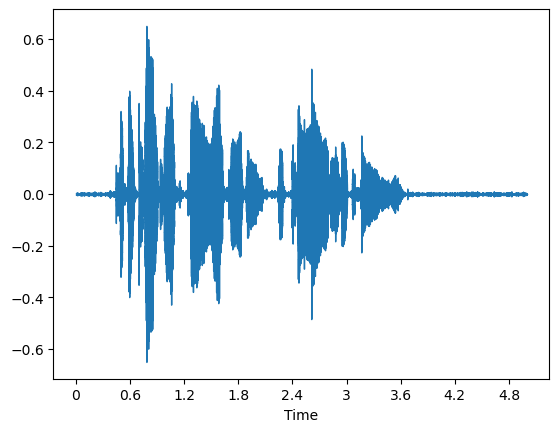

In [6]:
sound, sr = librosa.load(voice_path, sr = SAMPLE_RATE)
print(len(sound))
librosa.display.waveshow(sound, sr = SAMPLE_RATE)
Audio(sound, rate = SAMPLE_RATE)

In [7]:
class Voice_Dataset(Dataset):
    def __init__(self, source_voice_path, target_voice_path):
        self.source_voice_path = source_voice_path
        self.target_voice_path = target_voice_path

        self.source_voices = os.listdir(self.source_voice_path)
        self.target_voices = os.listdir(self.target_voice_path)
        self.source_voices.sort()
        self.target_voices.sort()

        self.source_voices_len = len(self.source_voices)
        self.target_voices_len = len(self.target_voices)

        self.dataset_length = min(self.source_voices_len, self.target_voices_len)
        self.ids = [idx for idx in range(self.dataset_length)]
        random.shuffle(self.ids)

    def __len__(self):
        return self.dataset_length

    def __getitem__(self, index):
        sequence_idx = self.ids[index]
        src_voice = os.path.join(
                                self.source_voice_path,
                                self.source_voices[sequence_idx]
                                )
        target_voice = os.path.join(
                                  self.target_voice_path,
                                  self.target_voices[sequence_idx]
                                  )
        src_voice, _ = librosa.load(src_voice, sr = SAMPLE_RATE)
        target_voice, _ = librosa.load(target_voice, sr = SAMPLE_RATE)
        # set unified size of sound wave
        src_voice, target_voice = fit_sound(src_voice), fit_sound(target_voice)
        src_voice_amp, _ = preprocess_sound(src_voice)
        target_voice_amp, _ = preprocess_sound(target_voice)
        
        src_voice_amp = amp_to_decibel(src_voice_amp)
        target_voice_amp = amp_to_decibel(target_voice_amp)
        src_voice_amp = torch.from_numpy(src_voice_amp)
        target_voice_amp = torch.from_numpy(target_voice_amp)
        return src_voice_amp.unsqueeze(0).to(torch.float32), target_voice_amp.unsqueeze(0).to(torch.float32)

In [8]:
# test dataloader
dataset = Voice_Dataset(src_speaker_path, target_speaker_path)
train_dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
train_iter = iter(train_dataloader)
training_batch = next(train_iter)
sp1, sp2 = training_batch
sp1, sp2 = sp1.squeeze(0), sp2.squeeze(0)
sp1, sp2 = sp1[0].numpy(), sp2[0].numpy()
print(sp1.shape)
print(sp2.shape)
voice_sp1 = librosa.griffinlim(decibel_revert(sp1))
voice_test1 = librosa.griffinlim(np.abs(decibel_revert(sp1)))
voice_sp2 = librosa.griffinlim(decibel_revert(sp2))

(257, 501)
(257, 501)


In [9]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_act, **kwargs):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels,**kwargs),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(inplace = True) if use_act else nn.Identity()
        )
    def forward(self, x):
        return self.conv(x)

class ConvBlockUp(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super().__init__()
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(inplace = True)
        )
    def forward(self, x):
        return self.conv(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            ConvBlock(channels, channels, use_act = True, kernel_size = 3, padding=(1,1)),
            ConvBlock(channels, channels, use_act = False, kernel_size = 3, padding=(1,1))
        )
    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, channels, num_features = 64, num_residuals = 9):
        super().__init__()
        self.initial = nn.Sequential(
            ConvBlock(in_channels = channels, out_channels = num_features, use_act = True, kernel_size = 7, stride = 1, padding = (3,3), padding_mode = 'reflect')
        )
        self.down_blocks = nn.ModuleList(
            [
                ConvBlock(in_channels = num_features, out_channels = 2*num_features, use_act = True, kernel_size = 3, stride = 2, padding = (1,1), padding_mode = "reflect"),
                ConvBlock(in_channels = 2*num_features, out_channels = 4*num_features, use_act = True, kernel_size = 3, stride = 2, padding = (1,1), padding_mode = "reflect")
            ]
        )
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(channels = 4*num_features) for _ in range(num_residuals)]
        )
        self.up_blocks = nn.ModuleList(
            [
                ConvBlockUp(in_channels = 4*num_features, out_channels = 2*num_features, kernel_size = 3, stride = 2, padding = (1,1)),
                ConvBlockUp(in_channels = 2*num_features, out_channels = num_features, kernel_size = 3, stride = 2, padding = (1,1))
            ]
        )
        self.out_layer = nn.Conv2d(in_channels = num_features, out_channels = channels, kernel_size=7, stride=1, padding=(3,3), padding_mode="reflect")
  
    def forward(self, x):
        x = self.initial(x)
        for down_block in self.down_blocks:
            x = down_block(x)
        x = self.res_blocks(x)
        for up_block in self.up_blocks:
            x = up_block(x)
        return self.out_layer(x)

In [10]:
import torch
import torch.nn as nn

class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, stride, 1, bias=True, padding_mode="reflect"),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class Discriminator(nn.Module):
    def __init__(self, in_channels=1, features=[64, 128, 256, 512]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(
                in_channels,
                features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect",
            ),
            nn.LeakyReLU(0.2, inplace=True),
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(Block(in_channels, feature, stride=1 if feature==features[-1] else 2))
            in_channels = feature
        layers.append(nn.Conv2d(in_channels, 1, kernel_size=(4,4), stride=1, padding=1, padding_mode="reflect"))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial(x)
        return torch.sigmoid(self.model(x))

In [11]:
generator = Generator(channels=1, num_residuals=9)
input_tensor = torch.tensor(np.random.randn(8, 1, 257, 501), dtype=torch.float32)
gen_result = generator(input_tensor)
print(gen_result.shape)

torch.Size([8, 1, 257, 501])


In [12]:
print(torch.cuda.memory_allocated())
print(torch.cuda.memory_cached())

0
0


C:\Users\micha\.conda\envs\voice\lib\site-packages\torch\cuda\memory.py:344: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(


In [13]:
# def train_fn(disc_target, disc_source, gen_source_target, gen_target_source, loader, opt_disc, opt_gen, l1, mse, d_scaler, g_scaler, config):
#     TARGET_REALS = 0
#     TARGET_FAKES = 0
#     loop = tqdm(loader, leave=True)

#     for idx, (source_voice, target_voice) in enumerate(loop):
#         source_voice = source_voice.to(config.DEVICE)
#         target_voice = target_voice.to(config.DEVICE)
#         # Train Discriminators
#         with torch.cuda.amp.autocast():
#             fake_target_voice = gen_source_target(source_voice)

#             d_target_voice_real = disc_target(target_voice)
#             d_target_voice_fake = disc_target(fake_target_voice.detach())

#             TARGET_REALS += d_target_voice_real.mean().item()
#             TARGET_FAKES += d_target_voice_fake.mean().item()

#             d_target_real_loss = mse(d_target_voice_real, torch.ones_like(d_target_voice_real))
#             d_target_fake_loss = mse(d_target_voice_fake, torch.zeros_like(d_target_voice_fake))
#             d_target_loss = d_target_real_loss + d_target_fake_loss

#             fake_source_voice = gen_target_source(target_voice)

#             d_src_real = disc_source(source_voice)
#             d_src_fake = disc_source(fake_source_voice.detach())

#             d_source_real_loss = mse(d_src_real, torch.ones_like(d_src_real))
#             d_source_fake_loss = mse(d_src_fake, torch.zeros_like(d_src_fake))
#             d_source_loss = d_source_real_loss + d_source_fake_loss

#             D_loss = (d_target_loss + d_source_loss)/2

#         opt_disc.zero_grad()
#         d_scaler.scale(D_loss).backward()
#         d_scaler.step(opt_disc)
#         d_scaler.update()
#         # Train Generators
#         with torch.cuda.amp.autocast():
#             # adversarial loss for both generators
#             d_target_fake = disc_target(fake_target_voice)
#             d_source_fake = disc_source(fake_source_voice)

#             loss_g_target = mse(d_target_fake, torch.ones_like(d_target_fake))
#             loss_g_source = mse(d_source_fake, torch.ones_like(d_source_fake))

#             # cycle loss
#             cycle_source = gen_target_source(fake_target_voice)
#             cycle_target = gen_source_target(fake_source_voice)
#             cycle_source_loss = l1(source_voice, cycle_source)
#             cycle_target_loss = l1(target_voice, cycle_target)

#             # identity loss (remove these for efficiency if you set lambda_identity=0)
#             identity_source = gen_target_source(source_voice)
#             identity_target = gen_source_target(target_voice)
#             identity_source_loss = l1(source_voice, identity_source)
#             identity_target_loss = l1(target_voice, identity_target)

#             G_loss = (
#                 loss_g_target
#                 + loss_g_source
#                 + cycle_source_loss * config.LAMBDA_CYCLE
#                 + cycle_target_loss * config.LAMBDA_CYCLE
#                 + identity_source_loss * config.LAMBDA_IDENTITY
#                 + identity_target_loss * config.LAMBDA_IDENTITY
#             )
#         opt_gen.zero_grad()
#         g_scaler.scale(G_loss).backward()
#         g_scaler.step(opt_gen)
#         g_scaler.update()
#         loop.set_postfix(H_real=TARGET_REALS/(idx+1), H_fake=TARGET_FAKES/(idx+1))

In [14]:
# def main(config):
#     disc_target = Discriminator(in_channels=1).to(config.DEVICE)
#     disc_source = Discriminator(in_channels=1).to(config.DEVICE)
#     gen_source_target = Generator(channels=1, num_residuals=9).to(config.DEVICE)
#     gen_target_source = Generator(channels=1, num_residuals=9).to(config.DEVICE)

#     opt_disc = torch.optim.Adam(
#         list(disc_target.parameters()) + list(disc_source.parameters()),
#         lr=config.LEARNING_RATE,
#         betas=(0.5, 0.999),
#     )

#     opt_gen = torch.optim.Adam(
#         list(gen_source_target.parameters()) + list(gen_target_source.parameters()),
#         lr=config.LEARNING_RATE,
#         betas=(0.5, 0.999),
#     )

#     if config.LOAD_MODEL:
#         load_checkpoint(
#             disc_target, opt_disc, config, config.CHECKPOINT_DISC_TARGET
#         )
#         load_checkpoint(
#             disc_source, opt_disc, config, config.CHECKPOINT_TRG_SRC
#         )
#         load_checkpoint(
#             gen_source_target, opt_gen, config, config.CHECKPOINT_GEN_TARGET
#         )
#         load_checkpoint(
#             gen_target_source, opt_gen, config, config.CHECKPOINT_GEN_SRC
#         )

#     L1 = nn.L1Loss()
#     mse = nn.MSELoss()

#     dataset = Voice_Dataset(source_voice_path = config.SRC_VOICE_PATH,
#                   target_voice_path = config.TARGET_VOICE_PATH)
#     loader = DataLoader(
#         dataset,
#         batch_size=config.BATCH_SIZE,
#         shuffle=False,
#         num_workers=config.NUM_WORKERS,
#         pin_memory=True
#     )
#     g_scaler = torch.cuda.amp.GradScaler()
#     d_scaler = torch.cuda.amp.GradScaler()

#     for epoch in range(config.CURRENT_EPOCH, config.NUM_EPOCHS):
#         print("epoch", epoch)
#         train_fn(disc_target, disc_source, gen_source_target, gen_target_source, loader, opt_disc, opt_gen, L1, mse, d_scaler, g_scaler, config)
#         if epoch % 2 == 0 and epoch != 0:
#             save_checkpoint(disc_target, opt_disc, config, filename=os.path.join(config.MODELS_PATH, f'disc_target{epoch}.pth'))
#             save_checkpoint(disc_source, opt_disc, config, filename=os.path.join(config.MODELS_PATH, f'disc_source{epoch}.pth'))
#             save_checkpoint(gen_target_source, opt_gen, config, filename=os.path.join(config.MODELS_PATH, f'gen_source{epoch}.pth'))
#             save_checkpoint(gen_source_target, opt_gen, config, filename=os.path.join(config.MODELS_PATH, f'gen_source{epoch}.pth'))

In [15]:
class Config:
    def __init__(self):
        self.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
        self.BATCH_SIZE = 4
        self.LEARNING_RATE = 1e-5
        self.LAMBDA_IDENTITY = 10.0
        self.LAMBDA_CYCLE = 10
        self.NUM_WORKERS = 0
        self.NUM_EPOCHS = 1000
        self.CURRENT_EPOCH = 0
        self.LOAD_MODEL = False
        self.CHECKPOINT_GEN_TARGET = "/content/gdrive/MyDrive/test/gen_target10.pth"
        self.CHECKPOINT_GEN_SRC = "/content/gdrive/MyDrive/test/gen_source10.pth"
        self.CHECKPOINT_DISC_TARGET = "/content/gdrive/MyDrive/test/disc_target10.pth"
        self.CHECKPOINT_TRG_SRC = "/content/gdrive/MyDrive/test/disc_source10.pth"
        self.SRC_VOICE_PATH = os.path.join("data", "voices_unzip", "speaker2")
        self.TARGET_VOICE_PATH = os.path.join("data", "voices_unzip", "speaker3")
        self.MODELS_PATH = "model-save-test"

In [16]:
def train_step(
        generator_src_trg,
        generator_trg_src,
        disc_src,
        disc_trg,
        train_loader,
        gen_optimizer,
        disc_optimizer,
        g_scaler,
        d_scaler,
        config
):
    loop = tqdm(train_loader, leave=True)
    # trainloader need to be tqdm style
    for idx, (real_A, real_B) in enumerate(loop):
        #
#         real_A = real_A.squeeze(1)
#         real_B = real_B.squeeze(1)
        
        real_A = real_A.to(config.DEVICE)
        real_B = real_B.to(config.DEVICE)
        with torch.cuda.amp.autocast():
            fake_B = generator_src_trg(real_A)
            cycle_A = generator_trg_src(fake_B)

            fake_A = generator_trg_src(real_B)
            cycle_B = generator_src_trg(fake_A)
            identity_A = generator_trg_src(real_A)
            identity_B = generator_src_trg(real_B)

            d_fake_A = disc_src(fake_A)
            d_fake_B = disc_trg(fake_B)
            d_fake_cycle_A = disc_src(cycle_A)
            d_fake_cycle_B = disc_trg(cycle_B)
            cycleLoss = torch.mean(
                torch.abs(real_A - cycle_A) + torch.mean(torch.abs(real_B - cycle_B))
            )

            identity_loss = torch.mean(
                torch.abs(real_A - identity_A) + torch.mean(torch.abs(real_B - identity_B))
            )

            generator_loss_A2B = torch.mean((1 - d_fake_B) ** 2)
            generator_loss_B2A = torch.mean((1 - d_fake_A) ** 2)

            generator_loss = generator_loss_A2B + generator_loss_B2A + config.LAMBDA_CYCLE * cycleLoss + \
                                config.LAMBDA_IDENTITY * identity_loss
        # add generator loss
        gen_optimizer.zero_grad()
        g_scaler.scale(generator_loss).backward()
        g_scaler.step(gen_optimizer)
        g_scaler.update()
        
        # discriminator train
        with torch.cuda.amp.autocast():
            d_real_A = disc_src(real_A)
            d_real_B = disc_trg(real_B)

            generated_A = generator_trg_src(real_B)
            d_fake_A = disc_src(generated_A)

            cycled_B = generator_src_trg(generated_A)
            d_cycled_B = disc_trg(cycled_B)

            generated_B = generator_src_trg(real_A)
            d_fake_B = disc_trg(generated_B)

            cycled_A = generator_trg_src(generated_B)
            d_cycled_A = disc_src(cycled_A)

            d_loss_A_real = torch.mean((1 - d_real_A) ** 2)
            d_loss_A_fake = torch.mean((0 - d_fake_A) ** 2)
            d_loss_A = (d_loss_A_real + d_loss_A_fake) / 2.0

            d_loss_B_real = torch.mean((1 - d_real_B) ** 2)
            d_loss_B_fake = torch.mean((0 - d_fake_B) ** 2)
            d_loss_B = (d_loss_B_real + d_loss_B_fake) / 2.0

            d_loss_A_cycled = torch.mean((0 - d_cycled_A) ** 2)
            d_loss_B_cycled = torch.mean((0 - d_cycled_B) ** 2)

            d_loss_A_2nd = (d_loss_A_real + d_loss_A_cycled) / 2.0
            d_loss_B_2nd = (d_loss_B_real + d_loss_B_cycled) / 2.0

            d_loss = (d_loss_A + d_loss_B) / 2.0 + (d_loss_A_2nd + d_loss_B_2nd) / 2.0
            # add to store d_loss
        disc_optimizer.zero_grad()
        d_scaler.scale(d_loss).backward()
        d_scaler.step(disc_optimizer)
        d_scaler.update()
        loop.set_postfix(
                        Gen_loss=generator_loss.item(),
                        Disc_loss = d_loss.item(),
                        Gen_loss_a2b = generator_loss_A2B.item(),
                        Gen_loss_b2a = generator_loss_B2A.item(),
                        Identity_loss = identity_loss.item(),
                        Cycle_loss = cycleLoss.item(),
                        Disc_loss_A = d_loss_A.item(),
                        Disc_loss_B = d_loss_B.item()
                        )

In [17]:
def main(config):
    generator_src_trg = Generator(channels=1, num_residuals=9).to(config.DEVICE)
    generator_trg_src = Generator(channels=1, num_residuals=9).to(config.DEVICE)
    disc_src = Discriminator().to(config.DEVICE)
    disc_trg = Discriminator().to(config.DEVICE)
    
    gen_optimizer = torch.optim.Adam(
        list(generator_src_trg.parameters()) + list(generator_trg_src.parameters()),
        lr=config.GEN_LR,
        betas=(0.5, 0.999),
    )
    discr_optimizer = torch.optim.Adam(
        list(disc_src.parameters()) + list(disc_trg.parameters()),
        lr=config.DISCR_LR,
        betas=(0.5, 0.999),
    )
    if config.LOAD_MODEL:
        load_checkpoint(
            config.CHECKPOINT_GEN_SRC_TRG, generator_src_trg, gen_optimizer, config.GEN_LR
        )
        load_checkpoint(
            config.CHECKPOINT_GEN_TRG_SRC, generator_trg_src, gen_optimizer, config.GEN_LR
        )
        #
        load_checkpoint(
            config.CHECKPOINT_DISC_SRC, disc_src, discr_optimizer, config.DISCR_LR
        )
        load_checkpoint(
            config.CHECKPOINT_DISC_TRG, disc_trg, discr_optimizer, config.DISCR_LR
        )
    dataset = Voice_Dataset(
                            source_voice_path = config.SRC_VOICE_PATH,
                            target_voice_path = config.TARGET_VOICE_PATH
                            )
    loader =  DataLoader(
                        dataset,
                        batch_size=config.BATCH_SIZE,
                        shuffle=True,
                        num_workers=config.NUM_WORKERS,
                        pin_memory=True
    )
    g_scaler = torch.cuda.amp.GradScaler()
    d_scaler = torch.cuda.amp.GradScaler()
    # Main epochs loop
    for epoch_idx in range(config.NUM_EPOCHS):
        config.CURRENT_EPOCH = epoch_idx
        train_step(
            generator_src_trg, generator_trg_src,
            disc_src, disc_trg,
            loader,
            gen_optimizer,
            discr_optimizer,
            g_scaler,
            d_scaler,
            config
        )
        if epoch % config.SAVE_FREQ and epoch != 0:
            save_checkpoint(disc_trg, discr_optimizer, filename=os.path.join(config.MODELS_PATH, f'disc_target{epoch}.pth'))
            save_checkpoint(disc_src, discr_optimizer, filename=os.path.join(config.MODELS_PATH, f'disc_source{epoch}.pth'))
            save_checkpoint(generator_src_trg, gen_optimizer, filename=os.path.join(config.MODELS_PATH, f'gen_src_trg{epoch}.pth'))
            save_checkpoint(generator_trg_src, gen_optimizer, filename=os.path.join(config.MODELS_PATH, f'gen_trg_src{epoch}.pth'))

In [18]:
class Config:
    def __init__(self):
        self.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
        self.BATCH_SIZE = 4
        
        self.GEN_LR = 2e-4
        self.DISCR_LR = 1e-4
        self.GEN_LR_DECAY = self.GEN_LR / 200000
        self.DISCR_LR_DECAY = self.DISCR_LR / 200000
        self.START_DECAY = 10000
        
        self.LAMBDA_CYCLE = 10.0
        self.LAMBDA_IDENTITY = 5.0
        
        self.NUM_WORKERS = 0
        self.NUM_EPOCHS = 1000
        self.CURRENT_EPOCH = 0
        self.LOAD_MODEL = False
        self.CHECKPOINT_GEN_SRC_TRG = None
        self.CHECKPOINT_GEN_TRG_SRC = None
        self.CHECKPOINT_DISC_TRG = None
        self.CHECKPOINT_DISC_SRC = None
        #
        self.SRC_VOICE_PATH = os.path.join("data", "voices_unzip", "speaker2")
        self.TARGET_VOICE_PATH = os.path.join("data", "voices_unzip", "speaker3")
        self.MODELS_PATH = "model-save-test"
        self.SAVE_FREQ = 100

In [19]:
config = Config()
main(config)

  3%|▎         | 9/283 [00:23<12:05,  2.65s/it, Cycle_loss=39.3, Disc_loss=0.436, Disc_loss_A=0.214, Disc_loss_B=0.219, Gen_loss=589, Gen_loss_a2b=0.32, Gen_loss_b2a=0.35, Identity_loss=39.2]  


KeyboardInterrupt: 